# NBA recommendation engine

### URLs
- https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints
- https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation#parameters-39
- https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/commonplayerinfo.md

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import requests
from bs4 import BeautifulSoup
import copy
import matplotlib.ticker as mtick
import time
from collections import Counter

In [2]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import teams

# Preparation of dataset (time-consuming, only executed once)

### List of all active players

In [3]:
# get_players returns a list of dictionaries, each representing a player.
nba_players = pd.DataFrame(players.get_active_players())
print(f'Number of players fetched: {len(nba_players)}')

Number of players fetched: 587


In [4]:
#nba_players['team'] = [list(commonplayerinfo.CommonPlayerInfo(player_id = p_id).get_data_frames()[0]['TEAM_ABBREVIATION'])[0] for p_id in nba_players['id']]
# retrieves team in current season, not last one

In [5]:
def player_name_by_id(p_id):
    return nba_players[nba_players['id'] == p_id]['full_name']

In [6]:
def adj_position(pos):
    if pos[0] in ['C', 'F', 'G']:
        return pos[0]
    else:
        print('Please enter a valid position.')
        pass

### Get all career data for all active players

In [ ]:
from nba_api.stats.endpoints import playercareerstats
import time

stats = list()

for player in tqdm(nba_players['id']):
    time.sleep(.600)
    call_career = playercareerstats.PlayerCareerStats(player_id=player) 
    # how to select data more efficiently, i.e. only last season?
    stats.append(call_career.get_data_frames()[0])

In [ ]:
stats_df = pd.concat(stats)
stats_df.to_csv('playercareerstats.csv', index = False)

### Subset only last season data & add positions of players

In [359]:
playercareerstats = pd.read_csv('playercareerstats.csv')

In [360]:
stats_lastSeason = playercareerstats[playercareerstats['SEASON_ID'] == '2020-21'].reset_index().drop(columns=['index'])

In [ ]:
# add positions of players
positions = []
for i in tqdm(range(stats_lastSeason.shape[0])):
    time.sleep(.600)
    positions.append(commonplayerinfo.CommonPlayerInfo(stats_lastSeason['PLAYER_ID'][i]).get_data_frames()[0]['POSITION'][0])
print(len(positions))

Counter([adj_position(position) for position in positions])

stats_lastSeason['POSITION'] = [adj_position(position) for position in positions]
stats_lastSeason.to_csv('stats_lastSeason.csv', index = False)

# Load and prepare data

## Read data

In [7]:
stats_lastSeason = pd.read_csv('stats_lastSeason.csv')

## Table of team information

In [8]:
data_teams = pd.DataFrame(teams.get_teams())
data_teams.head()

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


## Table of player information

In [9]:
players = list(stats_lastSeason['PLAYER_ID'].unique())

data_players = []
for i in range(len(players)):
    id_player = players[i]
    
    try:
        name_player = list(nba_players[nba_players['id'] == id_player]['full_name'])[0]    
    except IndexError: # not active anymore
        continue
        
    teams = list(stats_lastSeason[stats_lastSeason['PLAYER_ID'] == id_player]['TEAM_ABBREVIATION'])
    if teams[-1] == 'TOT':
        team_player = teams[-2]
    else:
        team_player = teams[-1]
    
    data_players.append({'id': id_player, 'name': name_player, 'team': team_player})

data_players = pd.DataFrame(data_players)
data_players.head()

# checken, dass nicht TOT
# team ID hinzufügen
# als CSV datei pushen

,id,name,team
0,203500,Steven Adams,NOP
1,1628389,Bam Adebayo,MIA
2,200746,LaMarcus Aldridge,BKN
3,1629638,Nickeil Alexander-Walker,NOP
4,1628960,Grayson Allen,MEM


In [10]:
# handle case that players where active for multiple teams last season -> only keep "TOT" (total) column

stats_LS = []
for player_id in stats_lastSeason["PLAYER_ID"].unique():
    stats_player = stats_lastSeason[stats_lastSeason["PLAYER_ID"] == player_id]
    if stats_player.shape[0] == 1:
        stats_LS.append(stats_player)
    else:
        stats_LS.append(stats_player[stats_player["TEAM_ABBREVIATION"] == 'TOT'])
        
stats_lastSeason = pd.concat(stats_LS).reset_index(drop = True)

In [11]:
stats_lastSeason

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,POSITION
0,203500,2020-21,0,1610612740,NOP,27.0,58,58,1605.0,189,...,213,301,514,111,54,38,78,113,438,C
1,1628389,2020-21,0,1610612748,MIA,23.0,64,64,2143.0,456,...,142,431,573,346,75,66,169,145,1197,C
2,200746,2020-21,0,0,TOT,35.0,26,23,674.0,140,...,19,99,118,49,11,29,27,47,352,C
3,1629638,2020-21,0,1610612740,NOP,22.0,46,13,1007.0,192,...,13,131,144,102,47,22,69,88,508,G
4,1628960,2020-21,0,1610612763,MEM,25.0,50,38,1260.0,173,...,19,141,160,108,46,8,48,71,532,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,1626153,2020-21,0,0,TOT,29.0,63,39,1748.0,240,...,65,204,269,278,101,30,83,75,645,G
431,201152,2020-21,0,1610612741,CHI,33.0,68,23,1652.0,370,...,168,255,423,291,74,40,137,152,823,F
432,1629027,2020-21,0,1610612737,ATL,22.0,63,63,2125.0,487,...,38,207,245,594,53,12,261,111,1594,G
433,203469,2020-21,0,1610612766,CHA,28.0,48,21,1005.0,181,...,119,209,328,86,27,17,51,121,451,F


## Salaries

In [12]:
def visualize_capspace(input_data, labels, team):
    x_values = ['2021/22', '2022/23', '2023/24', '2024/25']
    colors = ['blue', 'green', 'red']
    y_values = [list(input_data.iloc[i, 3:]) for i in range(input_data.shape[0])]
            
    fig, ax = plt.subplots(figsize=(12, 5))
    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label = labels[i], color= colors [i])
    ax.set(title = f' Cap Space Development of {team}',
           xlabel = "Season",
           ylabel = "Cap Space in $") # can be improved
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.0f $')) # can be improved
    plt.fill_between(x_values,y_values[0], y_values[-1],color="None",hatch=".",edgecolor="r")
    plt.legend()

    return plt.show()

### Team Salaries

In [13]:
#years = {'2020/21': '2020', '2021/22': '', '2022/23': '2022', '2023/24': '2023', '2024/25': '2024'}
years = {'2021/22': '', '2022/23': '2022', '2023/24': '2023', '2024/25': '2024'}

for y in years.keys():
    
    url = 'https://www.spotrac.com/nba/cap/' + years[y]
    r = requests.get(url, timeout=2.5)
    r_html = r.text
    soup = BeautifulSoup(r_html, 'html.parser')

    salary_table = soup.find('table')
    
    #if y == '2020/21':
    #    cap_space = [[salary_table.find_all("td")[i].text.strip() for i in [(j-1)*11+1, (j-1)*11+9]] for j in range(1, 31)]
    #    salary_cap_teams = pd.DataFrame(cap_space, columns=['Team', y])
    #    continue
    
    if y == '2021/22':
        cap_space = [[salary_table.find_all("td")[i].text.strip() for i in [(j-1)*12+1, (j-1)*12+9]] for j in range(1, 31)]
        salary_cap_teams = pd.DataFrame(cap_space, columns=['Team', y])
        print(y)
        continue
    else:
        cap_space = [[salary_table.find_all("td")[i].text.strip() for i in [(j-1)*11+1, (j-1)*11+8]] for j in range(1, 31)]
        print(y)
    
    
    salary_cap_year = pd.DataFrame(cap_space, columns=['Team', y])
#    salary_cap_year['Team'].astype(str)
    
    salary_cap_teams = salary_cap_teams.merge(salary_cap_year, on = 'Team', how = 'left')

2021/22
2022/23
2023/24
2024/25


In [14]:
salary_cap_teams.insert(1, 'Abb', salary_cap_teams['Team'].str[-3:])
salary_cap_teams['Team'] = salary_cap_teams['Team'].str[:-3]
salary_cap_teams.insert(0, 'Team_ID', [list(data_teams[data_teams['full_name'] == salary_cap_teams['Team'][i]]['id'])[0] for i in range(salary_cap_teams.shape[0])])

# lakers in 2021: -50 mil -> 50 mil over Cap

In [15]:
for col in salary_cap_teams.columns[3:]:
    salary_cap_teams[col] = salary_cap_teams[col].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)
        
salary_cap_teams

,Team_ID,Team,Abb,2021/22,2022/23,2023/24,2024/25
0,1610612760,Oklahoma City Thunder,OKC,24572406.0,-1848998.0,-9418667.0,41399666.0
1,1610612763,Memphis Grizzlies,MEM,-3347775.0,-15442836.0,-30850268.0,57216487.0
2,1610612740,New Orleans Pelicans,NOP,-4004104.0,-15614516.0,-45768872.0,-7268819.0
3,1610612766,Charlotte Hornets,CHA,-4490105.0,-18232263.0,-20502290.0,8171964.0
4,1610612752,New York Knicks,NYK,-5042436.0,-18174322.0,-35439037.0,-22895991.0
5,1610612759,San Antonio Spurs,SAS,-5498958.0,-5657182.0,6625794.0,23360149.0
6,1610612765,Detroit Pistons,DET,-12756440.0,19834484.0,8496824.0,34931858.0
7,1610612756,Phoenix Suns,PHX,-15959873.0,-54333058.0,-53905519.0,5154000.0
8,1610612745,Houston Rockets,HOU,-17647614.0,-21705994.0,-37760728.0,44214930.0
9,1610612753,Orlando Magic,ORL,-18026594.0,-49345552.0,-8848482.0,-22092877.0


In [16]:
# get all contents of website

  
#r = requests.get(url, timeout=2.5)
#r_html = r.text

#soup = BeautifulSoup(r_html, 'html.parser')

#salary_table = soup.find('table')

#data = [[salary_table.find_all("td")[i].text.strip() for i in range((j-1)*12, j*12)] for j in range(1, 30)]

#df = pd.DataFrame(data, 
#                  columns = ['Rank', 'Team', 'Win%', 'Signed', 'Avg. Age', 'Active Cap', 'Active Cap (Top 3)', 'Dead Cap', 'Total Cap', 'Cap Space', 'Projected Practical Cap Space', 'Hard-Capped']).set_index('Rank')
#df

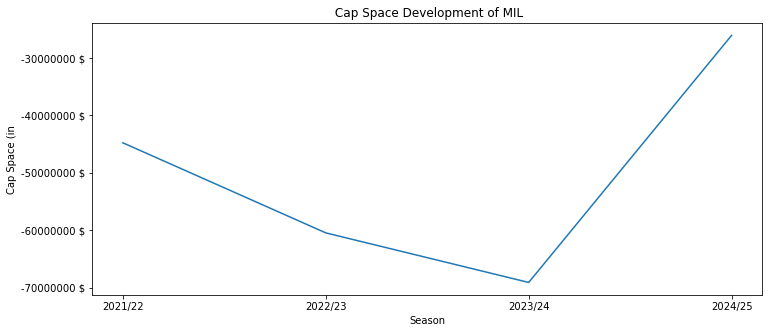

,Team_ID,Team,Abb,2021/22,2022/23,2023/24,2024/25
0,1610612749,Milwaukee Bucks,MIL,-44790900.0,-60471340.0,-69099482.0,-26087549.0


In [17]:
import matplotlib.ticker as mtick

def visualize_capspace_team(team_abb):
    if team_abb in list(salary_cap_teams['Abb']):
        capspace_team = salary_cap_teams[salary_cap_teams['Abb'] == team_abb].reset_index(drop = True)
        y_values = capspace_team.iloc[0, 3:]
    else:
        print('Please input a correct abbreviation of an NBA team')
        return 0
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(['2021/22', '2022/23', '2023/24', '2024/25'], list(y_values)) # 2020/21
    ax.set(title = f' Cap Space Development of {team_abb}',
           xlabel = "Season",
           ylabel = "Cap Space (in")
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.0f $')) # can be improved
    plt.show()
    return capspace_team

visualize_capspace_team('MIL')

## !! ändern zu Team_ID!

### Player salaries

In [18]:
url='https://hoopshype.com/salaries/players/'

r = requests.get(url, timeout=2.5)
r_html = r.text

soup = BeautifulSoup(r_html, 'html.parser')

salary_table = soup.find('table')

In [19]:
length=len(salary_table.find_all("td"))

player_names=[salary_table.find_all("td")[i].text.strip() for i in range(9,length,8)]

column1=[salary_table.find_all("td")[i].text.strip() for i in range(10,length,8)]
column2=[salary_table.find_all("td")[i].text.strip() for i in range(11,length,8)]
column3=[salary_table.find_all("td")[i].text.strip() for i in range(12,length,8)]
column4=[salary_table.find_all("td")[i].text.strip() for i in range(13,length,8)]
column5=[salary_table.find_all("td")[i].text.strip() for i in range(14,length,8)]
column6=[salary_table.find_all("td")[i].text.strip() for i in range(15,length,8)]

In [20]:
dict_df={'player_names':player_names,
       # '2019/20':column1,
       # '2020/21':column2,
        '2021/22':column3,
        '2022/23':column4,
        '2023/24':column5,
        '20124/25':column6}
        
player_salary=pd.DataFrame(dict_df)

In [21]:
player_salary

,player_names,2021/22,2022/23,2023/24,20124/25
0,Stephen Curry,"$51,915,615","$55,761,217","$59,606,817",$0
1,James Harden,$0,$0,$0,$0
2,John Wall,$0,$0,$0,$0
3,Russell Westbrook,$0,$0,$0,$0
4,LeBron James,$0,$0,$0,$0
...,...,...,...,...,...
531,Admiral Schofield,$0,$0,$0,$0
532,Troy Williams,$0,$0,$0,$0
533,Mamadi Diakite,$0,$0,$0,$0
534,Demetrius Jackson,"$92,857",$0,$0,$0


In [22]:
player_salary = player_salary.rename(columns={"20124/25": "2024/25"})

In [23]:
#salary_years = ['2019/20', '2020/21', '2021/22', '2022/23', '2023/24', '2024/25']
salary_years = ['2021/22', '2022/23', '2023/24', '2024/25']

In [24]:
for col in salary_years:
    player_salary[col] = player_salary[col].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)
    
# + also discount as in scratchpad.ipynb to get NPV?

### Current issue:

In [416]:
player_salary_player_ids = []
for i in range(player_salary.shape[0]):
    try:
        player_salary_player_ids.append(list(data_players[data_players['name'] == player_salary['player_names'][i]]['id'])[0])
    except:
        print(player_salary.iloc[i,:]['player_names'])
        
# have salary, but no data for last season

# fuzzymatch
# TJ -> T.J. (nicht RJ)
# Jr -> Jr.
# Schroeder -> Schroder

# Rookies entfernen

# Basis alle Spieler, der letzten 4 Saisons

# Contract player ids - rookies
# Contract palyer ids LEFT JOIN ids active past 4 seasons

# für jeden active player: ID

Klay Thompson
Tim Hardaway Jr
Jonathan Isaac
Gary Trent Jr
Marcus Morris
TJ Warren
Kelly Oubre
Marvin Bagley
Devonte Graham
Larry Nance Jr
Anthony Edwards
Cade Cunningham
Derrick Jones
Jaren Jackson Jr
James Wiseman
Jalen Green
LaMelo Ball
Evan Mobley
TJ McConnell
Patrick Williams
Scottie Barnes
PJ Tucker
Zach Collins
DJ Augustin
Wendell Carter
Juan Hernangomez
Isaac Okoro
Jalen Suggs
Cameron Payne
Joakim Noah
Onyeka Okongwu
Josh Giddey
Patrick Mills
Dennis Schroeder
Kevin Knox
Timofey Mozgov
Killian Hayes
Jonathan Kuminga
Michael Porter
Ryan Anderson
Troy Brown
Obi Toppin
Franz Wagner
Louis Williams
Luol Deng
Deni Avdija
Davion Mitchell
Ishmael Smith
Jalen Smith
Lonnie Walker
Ziaire Williams
Moe Harkless
Devin Vassell
PJ Washington
James Bouknight
Tyrese Haliburton
Josh Primo
Danuel House
Kira Lewis
Chris Duarte
Gabriel Deck
Robert Williams
Aaron Nesmith
Moses Moody
Cole Anthony
Corey Kispert
Isaiah Stewart
Chuma Okeke
Alperen Sengun
Facundo Campazzo
Jon Leuer
Aleksej Pokusevski
Trey 

In [386]:
data_players[data_players['name'] == 'Klay Thompson']

,id,name,team


In [358]:
pd.set_option('display.max_rows', None)

data_players['name'] # ???? active_players: players with minutes in past 2 seasons

0                  Steven Adams
1                   Bam Adebayo
2             LaMarcus Aldridge
3      Nickeil Alexander-Walker
4                 Grayson Allen
5                 Jarrett Allen
6               Al-Farouq Aminu
7                 Kyle Anderson
8         Giannis Antetokounmpo
9        Thanasis Antetokounmpo
10              Carmelo Anthony
11                   OG Anunoby
12             Ryan Arcidiacono
13                 Trevor Ariza
14                D.J. Augustin
15                Deandre Ayton
16                 Dwayne Bacon
17            Marvin Bagley III
18                   Lonzo Ball
19                     Mo Bamba
20              Harrison Barnes
21                   RJ Barrett
22                  Will Barton
23             Keita Bates-Diop
24                Nicolas Batum
25                Kent Bazemore
26                Darius Bazley
27                 Bradley Beal
28                Malik Beasley
29                  Jordan Bell
30              DeAndre' Bembry
31      

In [ ]:
# 1630163 LaMelo Ball

# Via boxplot: starting 5

In [393]:
player_salary

,player_names,2021/22,2022/23,2023/24,2024/25
0,Stephen Curry,51915615.0,55761217.0,59606817.0,0.0
1,James Harden,0.0,0.0,0.0,0.0
2,John Wall,0.0,0.0,0.0,0.0
3,Russell Westbrook,0.0,0.0,0.0,0.0
4,LeBron James,0.0,0.0,0.0,0.0
5,Kevin Durant,47649433.0,51179020.0,54708608.0,0.0
6,Paul George,45640165.0,48787763.0,0.0,0.0
7,Kawhi Leonard,45640084.0,48787676.0,0.0,0.0
8,Giannis Antetokounmpo,45640084.0,48787676.0,51935268.0,0.0
9,Damian Lillard,45640084.0,48787676.0,0.0,0.0


## Class definition

In [131]:
class RecommendationEngine:
    def __init__(self, replacing_player):
        self.player_name = replacing_player        
        try:
            self.player_id = nba_players[nba_players["full_name"] == replacing_player]['id'].iloc[0]
        except IndexError:
            print("Please provide the full name of a valid active NBA player.")
        self.position = adj_position(commonplayerinfo.CommonPlayerInfo(self.player_id).get_data_frames()[0]['POSITION'][0])
        self.team = self.team_lastSeason()
            
    def recommend(self):        
        stats = stats_lastSeason[(stats_lastSeason['POSITION'] == self.position)].drop(columns=['POSITION']) #get only players of same position
        #stats = stats_lastSeason.drop(columns=['POSITION'])
        
        stats_repl_player = stats[stats['PLAYER_ID'] == self.player_id].iloc[:,5:] # get data from player to be replaced
        stats = stats[stats['TEAM_ABBREVIATION'] != self.team] # exclude players from same team

        stats_num = stats.iloc[:,5:]
        
        if stats_repl_player.shape[0] != 0:
        
            # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
            model = NearestNeighbors(n_jobs = -1).fit(stats_num)

            res_distances, res_players = model.kneighbors(stats_repl_player, return_distance = True)
            res_distances, res_players = res_distances[0], res_players[0]
            res_player_0 = res_players[0]
            #if stats.reset_index()['PLAYER_ID'][res_player_0] == self.player_id: # excluded own team, so wont work anymore
            #    print("Clustering worked.")
                
            res_player_id = stats.reset_index()['PLAYER_ID'][res_player_0]
            rec_player = data_players[data_players['id'] == res_player_id]['name'].iloc[0]
            closest_players = []
            for i in range(len(res_players)):
                id_player = stats.reset_index()['PLAYER_ID'][res_players[i]]
                closest_players.append({'player': data_players[data_players['id'] == id_player]['name'].iloc[0],
                                        'distance': res_distances[i]})
            
            print(f'Input Player: {self.player_name} (Team: {self.team})')
            print('Salary:')
            salary_input_player = self.player_salary(self.player_name)
            display(salary_input_player)
            
            self.plot_distance(closest_players)
            
            
            print(f'\nRecommended Player: {rec_player}')
            print('Salary:')
            salary_rec_player = self.player_salary(rec_player)
            display(salary_rec_player)
            
            #print('-> Change in salary:')
            change_salary = self.change_salary(list(salary_input_player.iloc[0,1:]), list(salary_rec_player.iloc[0,1:]))
            #display(change_salary)
            
            #print('Salary Input Team:')
            team_salary = self.team_salary()
            #display(team_salary)
            
            limit_salary = self.limit_salary_team(team_salary)
        
            #print('New Salary Input Team:')
            new_team_salary = self.new_team_salary(change_salary, team_salary)
            #display(new_team_salary)
            
            visualize_capspace(team_salary.append(new_team_salary).append(limit_salary), 
                               ['Old Salary cap', f"New Salary cap by adding {rec_player}", 'Limit salary'],
                               self.team)

            return rec_player
        
        print("No data available for this player in the last season")
        pass
    
    
    
    def player_salary(self, rec_player):
        return player_salary[player_salary['player_names'] == rec_player]
    
    def change_salary(self, df_inputplayer, df_recplayer):
        # input - recommended
        return [float(df_inputplayer[i]) - float(df_recplayer[i]) for i in range(1, len(df_inputplayer))]
    
    def team_salary(self):
        # option with Commonplayerinfo (-> infos from this season (so, future))
        #data_rec_player = commonplayerinfo.CommonPlayerInfo(player_id=self.player_id) 
        # abb_team = list(data_rec_player.get_data_frames()[0]['TEAM_ABBREVIATION'])[0]
        
        abb_team = list(data_players[data_players['id'] == self.player_id]['team'])[0]
        return salary_cap_teams[salary_cap_teams['Abb'] == abb_team]
    
    def new_team_salary(self, change_salary, df_old_salary):
        df_new_salary = copy.copy(df_old_salary)
        for i in range(len(change_salary)):
            df_new_salary.iloc[0, 3+i] += change_salary[i]
        return df_new_salary
    
    
    def team_lastSeason(self):
        return list(stats_lastSeason[stats_lastSeason['PLAYER_ID'] == self.player_id]['TEAM_ABBREVIATION'])[0]
    
    def limit_salary_team(self, team_salary):
        df_limit_salary = copy.copy(team_salary)
        for i in range(3, df_limit_salary.shape[1]):
            if df_limit_salary.iloc[0, i] > 0:
                pass
            else:
                df_limit_salary.iloc[0, i] *= 1.1 # may overdraw another 10 %
        return df_limit_salary
    
    def plot_distance(self, dist_dict):
        #colors = ['blue', 'green', 'red']

        fig, ax = plt.subplots(figsize=(12, 5))
        x_values = [dist_dict[i]['distance'] for i in range(len(dist_dict))]
        x_values.append(0)
        y_values = (len(dist_dict)+1)*[0]
        colors = ['green']
        for i in range(len(y_values)-2):
            colors.append('blue')
        colors.append('red')
        
        ax.scatter(x_values, y_values, color = colors, s = 70)
        ax.set(title = f'Recommendation system for {self.player_name}', xlabel = "Distance")
        ax.axes.get_yaxis().set_visible(False)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        left_side = ax.spines["left"]
        left_side.set_visible(False)
        top_side = ax.spines["top"]
        top_side.set_visible(False)

       # plt.xticks(x, " ")
        #    plt.legend()

        ax.annotate(self.player_name, (x_values[-1], y_values[-1]), xytext = (x_values[-1], y_values[-1] + 0.02), arrowprops = {'arrowstyle': '->'} )
        for i in range(len(dist_dict)):
            ax.annotate(dist_dict[i]['player'], (x_values[i], y_values[i]), xytext = (x_values[i], y_values[i] + 0.02*np.power(-1, i)), arrowprops = {'arrowstyle': '->'} )
    
        return plt.show()
        
    

# constraint cap space einarbeiten

# gewichtete Durchschnitte
# nearest neighboar distance

# constraint cap space einarbeiten

# gewichtete Durchschnitte
# nearest neighboar distance

# Compare with list: current active players - rookies


## Exemplary execution

Input Player: Stephen Curry (Team: GSW)
Salary:


,player_names,2021/22,2022/23,2023/24,2024/25
0,Stephen Curry,51915615.0,55761217.0,59606817.0,0.0


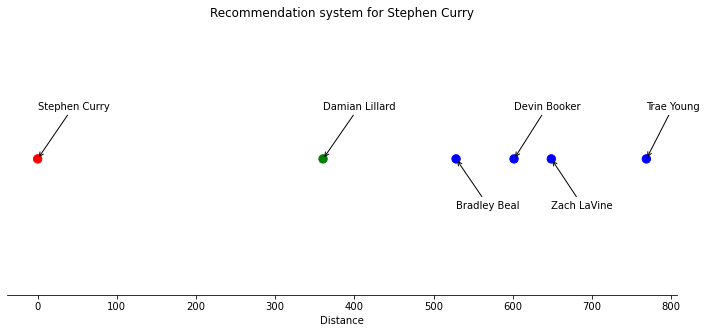


Recommended Player: Damian Lillard
Salary:


,player_names,2021/22,2022/23,2023/24,2024/25
9,Damian Lillard,45640084.0,48787676.0,0.0,0.0


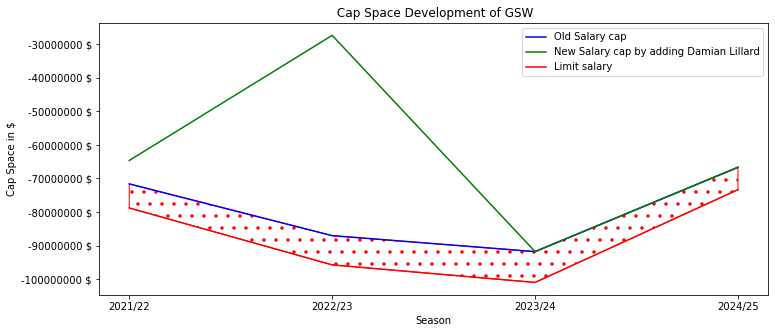

'Damian Lillard'

In [132]:
r1 = RecommendationEngine("Stephen Curry")
r1.recommend()

# TO-DO

- duplicate values of individual players in data for last season?
- Total-Zeile rausschmeißen?
- nur effiziente, alternativer pick
- welcher am besten mit anderen 4 Spielern passt —> machen evtl mehr punkte, assists als typischer spieler auf der position (10 most similar players) —> brauchen als neuen spieler jmd der mehr assists macht
- Salary zu NBA Daten mergen
- Fragen für Jonathan 
- more complex neighbor model
- how to treat players with no data in last season
- models vorher berechnen & nur most similar player rausgeben?
- visualization of distance of single player? -> embedding? 2D?
- exclude players that retired from last to this season
- how to deal with rookies coming into this season? -> ausschließen
- 2 strategien: ähnlich oder gut zu anderen passend
- exclude players that retired from last to this season
- Negativer Capspace -> letzten cap space +/- 10% auf plus & minus variieren (oder penalty function via betrag der negativität)
- team spalten ändern auf jahre
- alle spieler die für diese saison noch keine daten haben -> rookies ausschließen
- wenn recommendation, print old & new cap spaces where old one has bar showing lower limit

In [ ]:
stats_lastSeason.columns # -> adjust data by dividing by number of games?